<a href="https://colab.research.google.com/github/fiaazwa/DeepLearning/blob/main/DaapLearning02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 # === [1] Import Libraries ===
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
from torchvision.models.feature_extraction import create_feature_extractor

In [2]:
!python --version

Python 3.11.12


In [3]:
# === [2] Mount Google Drive ===
# Mount Google Drive agar bisa akses dataset
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Dataset_DeepLearning'
import os
print(os.listdir(data_dir))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['test', 'training', 'val', 'predict']


In [4]:
import os

# Ganti path ini ke folder dataset training kamu
train_dir = '/content/drive/MyDrive/Dataset_DeepLearning/training'  # Make sure this path is correct!

# Cek jumlah gambar di setiap subfolder (kelas)
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([file for file in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, file))])
        print(f"'{class_name}': {num_images} gambar")

'jaket': 310 gambar
'kaos': 310 gambar
'kemeja': 310 gambar
'gaun': 310 gambar


In [5]:
import torch, random, numpy as np

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)


In [6]:
# === [3] Data Transforms ===
# Transformasi data dan augmentasi
# transform_train = transforms.Compose([
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Crop acak dengan skala
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(degrees=15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Variasi warna
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translasi posisi
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
# ])
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [7]:
# === [4] Load Dataset ===
train_data = ImageFolder(os.path.join(data_dir, 'training'), transform=transform_train)
val_data = ImageFolder(os.path.join(data_dir, 'val'), transform=transform_test)
test_data = ImageFolder(os.path.join(data_dir, 'test'), transform=transform_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes

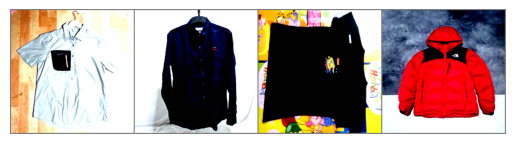

kemeja kemeja kaos jaket


In [8]:
# === [5] Visualize Sample Images ===
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join(f'{class_names[labels[j]]}' for j in range(4)))

In [9]:
# [6] Load Pretrained Model (ResNet50 + Dropout)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)  # Ganti ResNet18 dengan ResNet50
# Ambil jumlah fitur input dari FC terakhir
num_ftrs = model.fc.in_features

# Tambahkan Dropout dan ganti FC untuk jumlah kelas kamu
model.fc = nn.Sequential(
    nn.Dropout(0.5),                      # Dropout 50% (untuk regularisasi)
    nn.Linear(num_ftrs, len(class_names))  # Output sesuai jumlah kelas
)

# Pindahkan model ke device (GPU/CPU)
model = model.to(device)

# Tampilkan model untuk memverifikasi perubahan
print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
# === [7] Loss Function and Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [11]:
!pip install pytorch-ignite

In [12]:
# === [EarlyStopping Class] ===
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Save model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [13]:
# [8] Training Loop
early_stopping = EarlyStopping(patience=10, verbose=True)

epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

Epoch 1/50 | Train Loss: 0.8072 | Val Loss: 1.7535 | Train Acc: 70.97% | Val Acc: 52.78%
Validation loss decreased (inf → 1.753463). Saving model...
Epoch 2/50 | Train Loss: 0.4928 | Val Loss: 1.0383 | Train Acc: 82.50% | Val Acc: 65.00%
Validation loss decreased (1.753463 → 1.038326). Saving model...
Epoch 3/50 | Train Loss: 0.3624 | Val Loss: 1.0910 | Train Acc: 86.94% | Val Acc: 68.33%
EarlyStopping counter: 1 out of 10
Epoch 4/50 | Train Loss: 0.3120 | Val Loss: 0.7585 | Train Acc: 90.00% | Val Acc: 71.11%
Validation loss decreased (1.038326 → 0.758485). Saving model...
Epoch 5/50 | Train Loss: 0.2677 | Val Loss: 0.4996 | Train Acc: 90.65% | Val Acc: 80.56%
Validation loss decreased (0.758485 → 0.499599). Saving model...
Epoch 6/50 | Train Loss: 0.2629 | Val Loss: 1.6512 | Train Acc: 91.69% | Val Acc: 66.67%
EarlyStopping counter: 1 out of 10
Epoch 7/50 | Train Loss: 0.1681 | Val Loss: 0.4288 | Train Acc: 94.60% | Val Acc: 85.00%
Validation loss decreased (0.499599 → 0.428849). Sav

In [14]:
# # === [8] Training Loop ===
# from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
# from ignite.metrics import Accuracy, Loss
# from ignite.handlers import EarlyStopping

# import numpy as np
# import torch

# class EarlyStopping:
#     def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_loss = None
#         self.early_stop = False
#         self.val_loss_min = np.inf
#         self.delta = delta
#         self.path = path

#     def __call__(self, val_loss, model):
#         if self.best_loss is None:
#             self.best_loss = val_loss
#             self.save_checkpoint(val_loss, model)
#         elif val_loss > self.best_loss - self.delta:
#             self.counter += 1
#             if self.verbose:
#                 print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_loss = val_loss
#             self.save_checkpoint(val_loss, model)
#             self.counter = 0

#     def save_checkpoint(self, val_loss, model):
#         '''Save model when validation loss decrease.'''
#         if self.verbose:
#             print(f'Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model...')
#         torch.save(model.state_dict(), self.path)
#         self.val_loss_min = val_loss


# epochs = 50
# train_losses, val_losses = [], []
# train_accuracies, val_accuracies = [], []

# for epoch in range(epochs):
#     # --- Training Phase ---
#     model.train()
#     running_loss = 0.0
#     correct_train, total_train = 0, 0

#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         total_train += labels.size(0)
#         correct_train += (predicted == labels).sum().item()

#     train_loss = running_loss / len(train_loader)
#     train_acc = 100 * correct_train / total_train
#     train_losses.append(train_loss)
#     train_accuracies.append(train_acc)

#     # Validation
#     model.eval()
#     val_loss = 0.0
#     correct_val, total_val = 0, 0

#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)

#             val_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             total_val += labels.size(0)
#             correct_val += (predicted == labels).sum().item()

#     val_loss = val_loss / len(val_loader)
#     val_acc = 100 * correct_val / total_val
#     val_losses.append(val_loss)
#     val_accuracies.append(val_acc)

#     print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

#     # --- Early Stopping ---
#     early_stopping(val_loss, model)
#     if early_stopping.early_stop:
#         print("Early stopping triggered!")
#         break


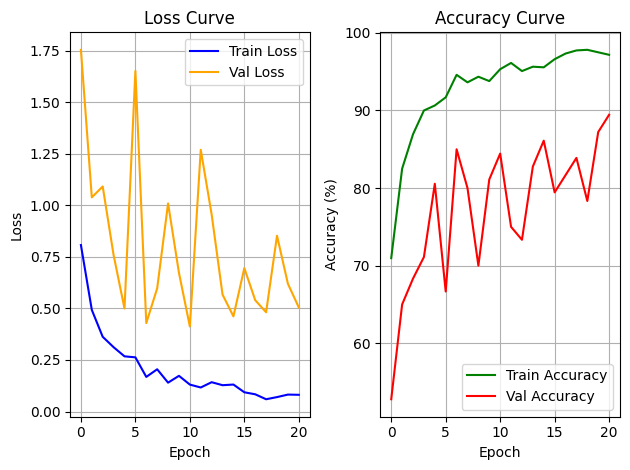

In [15]:
# === [9] Plotting Loss and Accuracy ===
# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(val_accuracies, label='Val Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

        gaun       0.71      0.82      0.76        45
       jaket       0.89      0.76      0.82        45
        kaos       0.77      0.89      0.82        45
      kemeja       0.76      0.64      0.70        45

    accuracy                           0.78       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.78      0.78      0.78       180



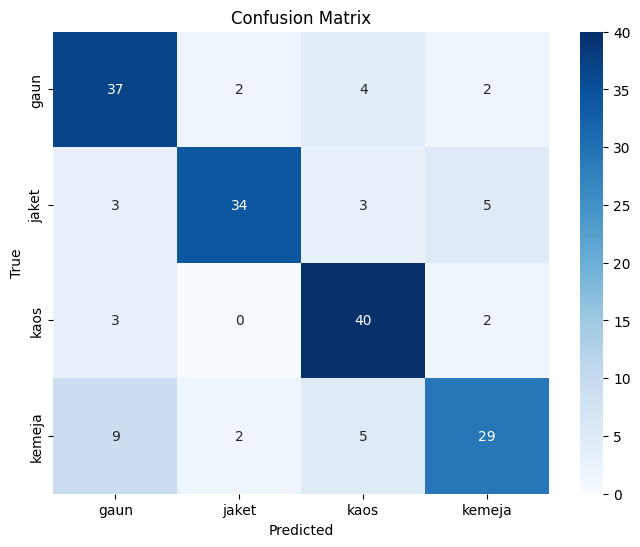

In [16]:
# === [10] Evaluate on Test Set ===
model.eval()
preds, truths = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.cpu().numpy())
        truths.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(truths, preds, target_names=class_names))

cm = confusion_matrix(truths, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# === [11] Error Rate Analysis ===
errors = [(p, t) for p, t in zip(preds, truths) if p != t]
print(f"Total Misclassified Samples: {len(errors)}")

Total Misclassified Samples: 40


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Shape of grad: torch.Size([2048, 7, 7])
Shape of act: torch.Size([2048, 7, 7])
Shape of pooled_grad: torch.Size([2048])


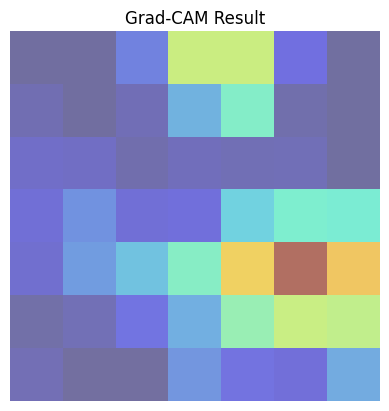

In [18]:
# === [12] Grad-CAM Visualization ===
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# --- Inisialisasi penyimpan ---
activations = {}
gradients = {}

# Fungsi hook
def forward_hook(module, input, output):
    activations['value'] = output

def backward_hook(module, grad_input, grad_output):
    gradients['value'] = grad_output[0]

# Pasang hook di layer terakhir convolution
target_layer = model.layer4[-1]

# Pasang hook
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)  # Ganti yang ini

# Fungsi gradcam
def generate_gradcam(image_tensor, class_idx=None):
    model.eval()
    activations.clear()
    gradients.clear()

    image_tensor = image_tensor.unsqueeze(0).to(device)  # [1, C, H, W]
    output = model(image_tensor)

    if class_idx is None:
        class_idx = torch.argmax(output)

    output[:, class_idx].backward()

    grad = gradients['value'].squeeze(0)        # [C, H, W]
    act = activations['value'].squeeze(0)       # [C, H, W]

    pooled_grad = grad.mean(dim=[1, 2])   # [C]
    print("Shape of grad:", grad.shape)
    print("Shape of act:", act.shape)
    print("Shape of pooled_grad:", pooled_grad.shape)

    for i in range(act.shape[0]):
        act[i] *= pooled_grad[i].item()  # <- Gunakan .item()

    heatmap = act.mean(dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)

    return heatmap

# ==== Menampilkan hasilnya ====

# Ambil contoh gambar dari test set
sample_img, _ = test_data[0]

# Generate heatmap
heatmap = generate_gradcam(sample_img)

# Konversi gambar asli ke format numpy
img = sample_img.permute(1, 2, 0).cpu().numpy()
img -= img.min()
img /= img.max()

# Tampilkan gambar asli + heatmap
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
plt.title("Grad-CAM Result")
plt.axis('off')
plt.show()

In [19]:
# === [13] Predict New Image ===
import os
from PIL import Image

def predict_from_folder(folder_path, model, transform, class_names):
    model.eval()
    predictions = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(img_tensor)
                _, pred = torch.max(output, 1)
                predicted_class = class_names[pred.item()]
                predictions.append((filename, predicted_class))

    return predictions

# === Jalankan Prediksi ===
predict_path = "/content/drive/MyDrive/Dataset_DeepLearning/predict"
results = predict_from_folder(predict_path, model, transform_test, class_names)

# === Tampilkan hasilnya ===
for fname, pred in results:
    print(f"{fname} => Predicted: {pred}")



img2.jpg => Predicted: gaun
img1.jpg => Predicted: jaket
img3.jpg => Predicted: kemeja
img5.jpg => Predicted: kemeja
img4.jpg => Predicted: kemeja
